<a href="https://colab.research.google.com/github/GarettGazay/ai_projects/blob/master/RBSeq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Understand the predictions better, what are are these vectors it returns? A: They are the model's attempt at becoming the target.

1. Verify the input and target data are in fact the same data with the input shuffled and the target in the correct order.

2. Use the padding function to pad each batch to the correct dims (125,12)

3. Take 2 random days out of the data and convert it into a validation set, then try to implement early stopping.

4. Mini-batch train so the model can learn more and perhaps become better at predictions.

5. If training on more data does not improve the model, try looking at the data to see if there should be more, different, or less.

### Prediction

- Correlate the predicted values with the input dataframe with headers, try to place the input data in order in a df with the predictions.

- Find the most closely related (prediction, rides) values and arrange them according to the prediction order.

- Walk through by creating a loop where we check for highest similarity between each ride in input_data and the predictions. Then order the rides in line with the predictions that way so it finds the most similar ride in inputs starting at the top of the predictions list.

- Getting some correct results, but many are still out of order.

- Check the accuracy of top 5 similarities

- It could be that the predictions are accurate to the the targets, but with cos_similiarity, but they are still not accurate to predict on the input data.

- May need to continue training the model to get better predictions.

- May need to train on more data to learn the human decision making rhythms and nuances to find the correct orderings.

- Thinking about this in terms of seq2seq, the model might not be very good at generalizing order of a single sequence having only trained on a single sequence. It may be that by training on many sequences, it will learn the nuance that guides it toward robust predictions.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import time

In [2]:
rides = pd.read_csv('/content/ordering_dataset.csv')

In [3]:
rides = rides.drop(['Unnamed: 0',
                    'order',
                    'rider.first_name',
                    'rider.last_name',
                    'pickup.event_location.address1',
                    'dropoff.event_location.address1',
                    'run_name_id',
                    'pickup_time',
                    ], axis=1)

In [4]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_month,pickup_day,pickup_hour,pickup_minute
0,0.857143,0.012314,0.10,0.169343,0.583333,-0.990825,0.848788,0.837838,-0.990424,0.848616,1.0,1.0,0.173913,0.517241
1,0.857143,0.006394,0.10,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
2,0.857143,0.003826,0.10,0.167883,0.833333,-0.990800,0.846893,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
3,0.285714,0.023389,0.05,0.202920,0.791667,-0.990521,0.846884,0.675676,-0.989395,0.845235,1.0,1.0,0.304348,0.206897
4,0.285714,0.018819,0.05,0.084672,0.750000,-0.989852,0.847646,0.729730,-0.989807,0.845745,1.0,1.0,0.347826,0.517241


In [5]:
rides = rides.astype('float32')

In [6]:
# Count the number of NaN values in each column
nan_counts = rides.isna().sum()

# Display the count of NaN values for each column
print(nan_counts)

space_type                          0
billable_distance                   1
run_name                            0
rider.mediroutes_rider_id           0
pickup.event_location.zip           0
pickup.event_location.longitude     1
pickup.event_location.latitude      1
dropoff.event_location.zip          0
dropoff.event_location.longitude    1
dropoff.event_location.latitude     1
pickup_month                        1
pickup_day                          1
pickup_hour                         1
pickup_minute                       1
dtype: int64


In [7]:
rides.fillna(0, inplace=True)

In [8]:
rides.dtypes

space_type                          float32
billable_distance                   float32
run_name                            float32
rider.mediroutes_rider_id           float32
pickup.event_location.zip           float32
pickup.event_location.longitude     float32
pickup.event_location.latitude      float32
dropoff.event_location.zip          float32
dropoff.event_location.longitude    float32
dropoff.event_location.latitude     float32
pickup_month                        float32
pickup_day                          float32
pickup_hour                         float32
pickup_minute                       float32
dtype: object

In [9]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_month,pickup_day,pickup_hour,pickup_minute
0,0.857143,0.012314,0.10,0.169343,0.583333,-0.990825,0.848788,0.837838,-0.990424,0.848616,1.0,1.0,0.173913,0.517241
1,0.857143,0.006394,0.10,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
2,0.857143,0.003826,0.10,0.167883,0.833333,-0.990800,0.846893,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
3,0.285714,0.023389,0.05,0.202920,0.791667,-0.990521,0.846884,0.675676,-0.989395,0.845235,1.0,1.0,0.304348,0.206897
4,0.285714,0.018819,0.05,0.084672,0.750000,-0.989852,0.847646,0.729730,-0.989807,0.845745,1.0,1.0,0.347826,0.517241


In [10]:
counts = rides.groupby(['pickup_month', 'pickup_day']).size().reset_index(name='counts')
counts['counts'].mean()

99.41875

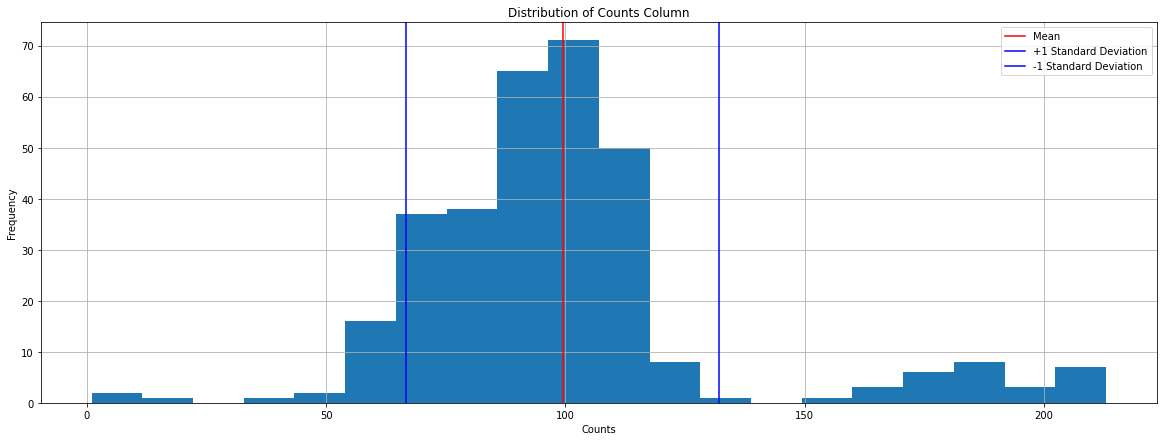

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))

import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean and standard deviation of the counts column
mean = counts['counts'].mean()
std = counts['counts'].std()

# Plot the histogram of the counts column
counts['counts'].hist(bins=20)

# Add vertical lines to indicate mean and standard deviation
plt.axvline(mean, color='red', label='Mean')
plt.axvline(mean + std, color='blue', label='+1 Standard Deviation')
plt.axvline(mean - std, color='blue', label='-1 Standard Deviation')

# Add title and labels
plt.title('Distribution of Counts Column')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.legend()

# Show plot
plt.show()

In [12]:
rides['pickup_day'] = rides['pickup_day'].fillna(0).astype(int)
rides['pickup_month'] = rides['pickup_month'].fillna(0).astype(int)

rides['pickup_day'] = rides['pickup_day'].astype(str)
rides['pickup_month'] = rides['pickup_month'].astype(str)

rides['id'] = rides['pickup_month'] + rides['pickup_day']

rides = rides.drop(['pickup_month','pickup_day'], axis=1)

In [13]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_hour,pickup_minute,id
0,0.857143,0.012314,0.10,0.169343,0.583333,-0.990825,0.848788,0.837838,-0.990424,0.848616,0.173913,0.517241,11
1,0.857143,0.006394,0.10,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,0.217391,0.517241,11
2,0.857143,0.003826,0.10,0.167883,0.833333,-0.990800,0.846893,0.797297,-0.990674,0.847189,0.217391,0.517241,11
3,0.285714,0.023389,0.05,0.202920,0.791667,-0.990521,0.846884,0.675676,-0.989395,0.845235,0.304348,0.206897,11
4,0.285714,0.018819,0.05,0.084672,0.750000,-0.989852,0.847646,0.729730,-0.989807,0.845745,0.347826,0.517241,11


In [14]:
rides.shape

(31814, 13)

In [15]:
rides = rides.astype(str)

In [16]:
rides.values[0].astype('float32')

array([ 0.85714287,  0.01231362,  0.1       ,  0.16934307,  0.5833333 ,
       -0.9908254 ,  0.8487879 ,  0.8378378 , -0.9904242 ,  0.8486156 ,
        0.17391305,  0.51724136, 11.        ], dtype=float32)

# DAY NUMBER WE ARE TRAINING - SET IT HERE FOR ALL BELOW CODE

In [17]:
day_of_rides = 0

Put rides into buckets by date

In [18]:
# Group the rows by the 'id' column
grouped = rides.groupby('id')

# Create a list to store the grouped arrays
day_buckets = []

# Loop through each group
for name, group in grouped:
    # Convert the group to a numpy array
    group_array = group.values.astype(np.float32)
    
    # Append the group array to the list of grouped arrays
    day_buckets.append(group_array)

# Set the display format of the numpy arrays
np.set_printoptions(precision=6, suppress=True)

# Sort the list of grouped arrays by the first column of each array
day_buckets.sort(key=lambda x: x[0][1])


In [19]:
# Do this or when you shuffle below it will shuffle both for some fucking reason, and copy doesn't work.
day_buckets_y = [x.astype(str) for x in day_buckets[1:]]

In [20]:
day_buckets_y[0][0]

array(['0.2857143', '0.0032280714', '0.2', '0.13868614', '0.6805556',
       '-0.990954', '0.8473343', '0.7972973', '-0.99070346', '0.84737885',
       '0.17391305', '0.25862068', '913.0'], dtype='<U32')

In [21]:
def shuffle_np_array(np_array_list):
    for i in range(len(np_array_list)):
        np.random.shuffle(np_array_list[i])
    return np_array_list

day_buckets_X = shuffle_np_array(day_buckets)[1:] # create a shuffled version for X below

In [22]:
input = []
target = []
for array in day_buckets_X:
    new_array = np.delete(array, -1, axis=1)
    input.append(new_array.astype('float32'))

count = 0
for array in day_buckets_y:
    new_array = np.delete(array, -1, axis=1)
    target.append(new_array.astype('float32'))


In [23]:
def pad_array(arr):
    padding = np.zeros((1, 12))
    while arr.shape[0] < 125:
        arr = np.concatenate((arr, padding), axis=0)
    return arr
    
input[day_of_rides] = pad_array(input[day_of_rides])
target[day_of_rides] = pad_array(target[day_of_rides])

In [24]:
def create_validation_set():
  random_validation_set = np.random.randint(0, len(day_buckets_X))

  if not random_validation_set == day_of_rides:
    print('random_validation_set: ', random_validation_set)
    print('day_of_rides: ', day_of_rides)
    X_val = input[-1].astype('float32')
    X_val = pad_array(X_val)

    y_val = target[-1].astype('float32')
    y_val = pad_array(y_val)

    return X_val, y_val
  else:
    print('Random integer happens to be the day_of_rides, cannot continue because the validation set should not be day of rides.')

X_val, y_val = create_validation_set()


random_validation_set:  246
day_of_rides:  0


In [25]:
input_df = pd.DataFrame(input[day_of_rides], columns=[
'input_space_type',
'input_billable_distance',
'input_run_name',
'input_rider.mediroutes_rider_id',
'input_pickup.event_location.zip',
'input_pickup.event_location.longitude',
'input_pickup.event_location.latitude',
'input_dropoff.event_location.zip',
'input_dropoff.event_location.longitude',
'input_dropoff.event_location.latitude',
'input_pickup_hour',
'input_pickup_minute'
])

target_df = pd.DataFrame(target[day_of_rides], columns=[
'target_space_type',
'target_billable_distance',
'target_run_name',
'target_rider.mediroutes_rider_id',
'target_pickup.event_location.zip',
'target_pickup.event_location.longitude',
'target_pickup.event_location.latitude',
'target_dropoff.event_location.zip',
'target_dropoff.event_location.longitude',
'target_dropoff.event_location.latitude',
'target_pickup_hour',
'target_pickup_minute'
])

check = pd.concat([input_df, target_df], axis=1)

In [26]:
input[day_of_rides][0]

array([ 0.285714,  0.022562,  0.8     ,  0.144526,  0.513889, -0.990927,
        0.845252,  0.675676, -0.989585,  0.845496,  0.521739,  0.517241])

In [27]:
target[day_of_rides][0]

array([ 0.285714,  0.003228,  0.2     ,  0.138686,  0.680556, -0.990954,
        0.847334,  0.797297, -0.990703,  0.847379,  0.173913,  0.258621])

In [28]:
input[day_of_rides].shape

(125, 12)

In [29]:
target[day_of_rides].shape

(125, 12)

In [30]:
# Define the input and output shape
input_shape = (125, 12)
output_shape = (125, 12)

Set the day to train on

In [31]:
input = input[day_of_rides]
target = target[day_of_rides]

In [32]:
# model = keras.models.load_model('/content/drive/MyDrive/Colab_Models/RBSeq2Seq')

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [34]:
input = input.reshape(1, *input.shape)
target = target.reshape(1, *target.shape)
X_val = X_val.reshape(1, *X_val.shape)
y_val = y_val.reshape(1, *y_val.shape)

print(input.shape)
print(target.shape)
print(X_val.shape)
print(y_val.shape)

# Define the encoder
encoder_inputs = keras.layers.Input(shape=input_shape)
encoder = keras.layers.LSTM(64, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Define the decoder
decoder_inputs = keras.layers.Input(shape=(None, 12))
decoder_lstm = keras.layers.LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Add the attention mechanism
attention = keras.layers.Attention()([decoder_outputs, encoder_outputs])
decoder_outputs = keras.layers.Concatenate()([decoder_outputs, attention])

decoder_dense = keras.layers.Dense(12, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error')


(1, 125, 12)
(1, 125, 12)
(1, 125, 12)
(1, 125, 12)


In [35]:
#  validation_data=([X_val, y_val], y_val), the first element of the tuple, [X_val, y_val], are the inputs to the model during validation. The second element of the tuple, y_val, is the expected target output during validation.

# Train the model
history = model.fit([input, target], target, epochs=400, batch_size=16, validation_data=([X_val, y_val], y_val), callbacks=[early_stopping], verbose=2)

Epoch 1/400
1/1 - 5s - loss: 0.3318 - val_loss: 0.3186 - 5s/epoch - 5s/step
Epoch 2/400
1/1 - 0s - loss: 0.2922 - val_loss: 0.2779 - 111ms/epoch - 111ms/step
Epoch 3/400
1/1 - 0s - loss: 0.2559 - val_loss: 0.2403 - 138ms/epoch - 138ms/step
Epoch 4/400
1/1 - 0s - loss: 0.2222 - val_loss: 0.2055 - 107ms/epoch - 107ms/step
Epoch 5/400
1/1 - 0s - loss: 0.1911 - val_loss: 0.1733 - 110ms/epoch - 110ms/step
Epoch 6/400
1/1 - 0s - loss: 0.1623 - val_loss: 0.1438 - 99ms/epoch - 99ms/step
Epoch 7/400
1/1 - 0s - loss: 0.1360 - val_loss: 0.1174 - 102ms/epoch - 102ms/step
Epoch 8/400
1/1 - 0s - loss: 0.1125 - val_loss: 0.0948 - 98ms/epoch - 98ms/step
Epoch 9/400
1/1 - 0s - loss: 0.0924 - val_loss: 0.0770 - 97ms/epoch - 97ms/step
Epoch 10/400
1/1 - 0s - loss: 0.0766 - val_loss: 0.0652 - 117ms/epoch - 117ms/step
Epoch 11/400
1/1 - 0s - loss: 0.0661 - val_loss: 0.0597 - 100ms/epoch - 100ms/step
Epoch 12/400
1/1 - 0s - loss: 0.0611 - val_loss: 0.0596 - 109ms/epoch - 109ms/step
Epoch 13/400
1/1 - 0s - l

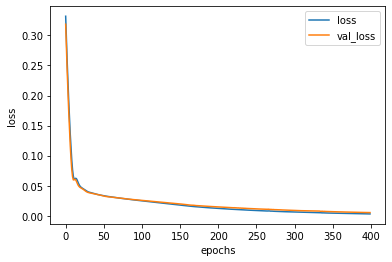

In [36]:
# Plot history (also known as a loss curve)
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

predict the vehicle for a ride by including the vehicle information in the input and target data and leaving a placeholder (e.g. zero) in place of the vehicle information at the time of prediction

In [37]:
model.save('/content/drive/MyDrive/Colab_Models/RBSeq2Seq')

In [38]:
pred = model.predict([input, target])

1/1 [==============================] - 2s 2s/step


In [41]:
pred[0][0]

array([ 0.330498, -0.01799 ,  0.170429,  0.113375,  0.708165, -1.022496,
        0.843465,  0.755957, -0.997315,  0.857954,  0.16966 ,  0.255369],
      dtype=float32)

In [42]:
target[0][0]

array([ 0.285714,  0.003228,  0.2     ,  0.138686,  0.680556, -0.990954,
        0.847334,  0.797297, -0.990703,  0.847379,  0.173913,  0.258621])

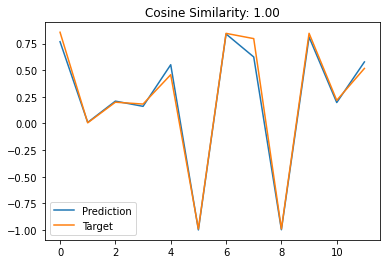

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def plot_vectors_cosine_similarity(vector1, vector2):
    similarity = cosine_similarity([vector1], [vector2])[0][0]
    fig, ax = plt.subplots()
    ax.plot(vector1, label='Prediction')
    ax.plot(vector2, label='Target')
    ax.set_title('Cosine Similarity: {:.2f}'.format(similarity))
    ax.legend()
    plt.show()
plot_vectors_cosine_similarity(pred[0][2], target[0][2])

In [44]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_cos_similiar(compare_against, pred):
  # Calculate cosine similarity between input data and predictions
  cos_similarity = cosine_similarity(compare_against, pred)

  # Get the cosine similarity value for each prediction-compare_against pair
  cosine_similarity_values = [cos_similarity[i][i] for i in range(len(cos_similarity))]

  return cosine_similarity_values

Loop through predictions comparing the similarity between each ride in the input vector, whichever ride has the highest similarity, add to another list which is the predicted rides order.

In [45]:
def comparison_ordering(master, slave):
  """ Compares and orders the inputs by the preds """

  max_finder = pd.DataFrame(columns=["pred", "original_input", "cos_similarity"])
  ordered_rides = pd.DataFrame(columns = [
    'space_type',
    'billable_distance',
    'run_name',
    'rider.mediroutes_rider_id',
    'pickup.event_location.zip',
    'pickup.event_location.longitude',
    'pickup.event_location.latitude',
    'dropoff.event_location.zip',
    'dropoff.event_location.longitude',
    'dropoff.event_location.latitude',
    'pickup_hour',
    'pickup_minute',
    'prediction_highest_scores',
    'similarity_high_score'
  ])

  for i in master: # order the j vector by the master
    for j in slave:
      cos_similarity = cosine_similarity(i.reshape(1, -1), j.reshape(1, -1))

      # Add mapping to max finder
      row = {"pred": i, "original_input": j, "cos_similarity": cos_similarity}
      max_finder = max_finder.append(row, ignore_index=True)

    # Find the winner
    max_row_index = np.argmax(max_finder['cos_similarity'])
    most_similar = max_finder.loc[max_row_index]

    # Get prediction info - just a check to see if max_row_index is returning the best value every time.
    max_finder.sort_values(by='cos_similarity', ascending=False, inplace=True)
    scores = max_finder['cos_similarity'][:3]
    scores = [round(x[0][0],4) for x in scores]

    highest_score = np.amax(scores)
    prediction_info = [np.sort(scores), highest_score]

    # Add most similar ride to ordered rides in order of predictions against the target
    row = {'space_type' : most_similar[1][0],
    'billable_distance' : most_similar[1][1],
    'run_name' : most_similar[1][2],
    'rider.mediroutes_rider_id' : most_similar[1][3],
    'pickup.event_location.zip' : most_similar[1][4],
    'pickup.event_location.longitude' : most_similar[1][5],
    'pickup.event_location.latitude' : most_similar[1][6],
    'dropoff.event_location.zip' : most_similar[1][7],
    'dropoff.event_location.longitude' : most_similar[1][8],
    'dropoff.event_location.latitude' : most_similar[1][9],
    'pickup_hour' : most_similar[1][10],
    'pickup_minute' : most_similar[1][11],
    'prediction_highest_scores' : prediction_info[:-1],
    'similarity_high_score' : prediction_info[1]
    }
    
    ordered_rides = ordered_rides.append(row, ignore_index=True)

    # Reset max finder so it starts empty for the next iteration
    max_finder = pd.DataFrame(columns=["pred", "original_input", "cos_similarity"])
    scores = []
  return ordered_rides

ordered_rides = comparison_ordering(pred[0], input[0])

In [46]:
ordered_rides.iloc[:10,:]

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_hour,pickup_minute,prediction_highest_scores,similarity_high_score
0,0.285714,0.003228,0.20,0.138686,0.680556,-0.990954,0.847334,0.797297,-0.990703,0.847379,0.173913,0.258621,"[[0.9847, 0.9899, 0.9992]]",0.9992
1,0.857143,0.012053,0.20,0.061314,0.472222,-0.991429,0.847318,0.121622,-0.991856,0.848719,0.173913,0.775862,"[[0.9793, 0.9817, 0.9936]]",0.9936
2,0.857143,0.006394,0.20,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,0.217391,0.517241,"[[0.9914, 0.992, 0.9953]]",0.9953
3,0.285714,0.011718,0.20,0.102190,0.458333,-0.990903,0.846275,0.662162,-0.990333,0.845598,0.217391,0.775862,"[[0.983, 0.9855, 0.9898]]",0.9898
4,0.857143,0.002593,0.25,0.090511,0.833333,-0.990608,0.847115,0.797297,-0.990657,0.847092,0.347826,0.258621,"[[0.9928, 0.9948, 0.9955]]",0.9955
5,0.857143,0.007192,0.25,0.389781,0.791667,-0.990329,0.847165,0.797297,-0.990656,0.847092,0.217391,0.258621,"[[0.9923, 0.9959, 0.9987]]",0.9987
6,0.857143,0.007928,0.40,0.445255,0.750000,-0.989875,0.847676,0.702703,-0.989680,0.846953,0.217391,0.258621,"[[0.9849, 0.9943, 0.9985]]",0.9985
7,0.857143,0.007688,0.40,0.078832,0.750000,-0.989987,0.847443,0.702703,-0.989686,0.846973,0.217391,0.517241,"[[0.9886, 0.9936, 0.9975]]",0.9975
8,0.285714,0.011718,0.20,0.102190,0.458333,-0.990903,0.846275,0.662162,-0.990333,0.845598,0.217391,0.775862,"[[0.9826, 0.9862, 0.9956]]",0.9956
9,0.857143,0.022823,0.00,0.290511,0.166667,-0.993161,0.851034,0.121622,-0.991972,0.849073,0.347826,0.000000,"[[0.9671, 0.98, 0.9885]]",0.9885


In [47]:
target_df.iloc[:10,:]

,target_space_type,target_billable_distance,target_run_name,target_rider.mediroutes_rider_id,target_pickup.event_location.zip,target_pickup.event_location.longitude,target_pickup.event_location.latitude,target_dropoff.event_location.zip,target_dropoff.event_location.longitude,target_dropoff.event_location.latitude,target_pickup_hour,target_pickup_minute
0,0.285714,0.003228,0.20,0.138686,0.680556,-0.990954,0.847334,0.797297,-0.990703,0.847379,0.173913,0.258621
1,0.857143,0.012053,0.20,0.061314,0.472222,-0.991429,0.847318,0.121622,-0.991856,0.848719,0.173913,0.775862
2,0.857143,0.006394,0.20,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,0.217391,0.517241
3,0.285714,0.011718,0.20,0.102190,0.458333,-0.990903,0.846275,0.662162,-0.990333,0.845598,0.217391,0.775862
4,0.857143,0.017380,0.25,0.119708,0.916667,-0.990598,0.849091,0.797297,-0.990656,0.847092,0.217391,0.000000
5,0.857143,0.007192,0.25,0.389781,0.791667,-0.990329,0.847165,0.797297,-0.990656,0.847092,0.217391,0.258621
6,0.857143,0.007928,0.40,0.445255,0.750000,-0.989875,0.847676,0.702703,-0.989680,0.846953,0.217391,0.258621
7,0.857143,0.007688,0.40,0.078832,0.750000,-0.989987,0.847443,0.702703,-0.989686,0.846973,0.217391,0.517241
8,0.142857,0.029168,0.10,0.077372,0.319444,-0.992498,0.850242,0.540541,-0.991170,0.847663,0.304348,0.775862
9,0.857143,0.022823,0.00,0.290511,0.166667,-0.993161,0.851034,0.121622,-0.991972,0.849073,0.347826,0.000000


In [74]:
target_df = pd.DataFrame(target[0], columns=[
  'space_type',
  'billable_distance',
  'run_name',
  'rider.mediroutes_rider_id',
  'pickup.event_location.zip',
  'pickup.event_location.longitude',
  'pickup.event_location.latitude',
  'dropoff.event_location.zip',
  'dropoff.event_location.longitude',
  'dropoff.event_location.latitude',
  'pickup_hour',
  'pickup_minute'
])

In [77]:
target_df.head(10)

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_hour,pickup_minute
0,0.285714,0.003228,0.20,0.138686,0.680556,-0.990954,0.847334,0.797297,-0.990703,0.847379,0.173913,0.258621
1,0.857143,0.012053,0.20,0.061314,0.472222,-0.991429,0.847318,0.121622,-0.991856,0.848719,0.173913,0.775862
2,0.857143,0.006394,0.20,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,0.217391,0.517241
3,0.285714,0.011718,0.20,0.102190,0.458333,-0.990903,0.846275,0.662162,-0.990333,0.845598,0.217391,0.775862
4,0.857143,0.017380,0.25,0.119708,0.916667,-0.990598,0.849091,0.797297,-0.990656,0.847092,0.217391,0.000000
5,0.857143,0.007192,0.25,0.389781,0.791667,-0.990329,0.847165,0.797297,-0.990656,0.847092,0.217391,0.258621
6,0.857143,0.007928,0.40,0.445255,0.750000,-0.989875,0.847676,0.702703,-0.989680,0.846953,0.217391,0.258621
7,0.857143,0.007688,0.40,0.078832,0.750000,-0.989987,0.847443,0.702703,-0.989686,0.846973,0.217391,0.517241
8,0.142857,0.029168,0.10,0.077372,0.319444,-0.992498,0.850242,0.540541,-0.991170,0.847663,0.304348,0.775862
9,0.857143,0.022823,0.00,0.290511,0.166667,-0.993161,0.851034,0.121622,-0.991972,0.849073,0.347826,0.000000
